# Trabalho A1 - Análise de Séries Temporais

## Instruções do Trabalho



**Linguagem de Programação:** Você pode utilizar Python ou R como linguagem de programação.

## Requisitos do Trabalho

Seu trabalho deve conter:

* **Discussão sobre métricas e métodos de avaliação**

* **Discussão sobre a necessidade de transformação de variáveis**

* **Discussão sobre a necessidade de decomposição entre tendência e sazonalidade**

* **Análises de resíduos e ajuste dos modelos**

* **Modelos baselines**

* **Modelos de regressão linear múltipla** utilizando co-variáveis criadas baseadas nas variáveis `week` e `volume`

## Entrega

Sua entrega deve conter:
- Link para um repositório no GitHub contendo o código
- Relatório de no máximo 5 páginas contendo um resumo executivo das suas análises


## Contexto

Ao longo do curso será disponibilizado mais variáveis para melhorar os resultados obtidos na A1.

Código Python completo e bem comentado para análise de séries temporais do dataset `data.csv`.

Este script cobre:
 - Análise exploratória (visualizações e estatísticas)
 - Métricas de avaliação (MAE, RMSE, MAPE)
 - Transformações (log, Box-Cox, diferenciação)
 - Testes de estacionariedade (ADF, KPSS)
 - Decomposição (trend/seasonal/residual)
 - Baselines (Naive, Seasonal Naive, Rolling mean)
 - Regressão linear múltipla com variáveis de tempo (tendência, sen/cos sazonais, dummies)
 - Modelos clássicos (ARIMA/SARIMA via pmdarima e statsmodels)
 - Diagnóstico de resíduos (ACF/PACF, Ljung-Box, histogramas)
 - Comparação de modelos e exportação de resultados

In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


!pip install statsmodels pmdarima scipy
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: C:\Users\dudda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# Funções utilitárias

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mape(y_true, y_pred):
    # evitar divisão por zero — retorna np.nan onde y_true==0
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


def train_test_split_ts(df, test_size=0.2):
    # split temporal: últimos test_size (proporção) usados como teste
    n = len(df)
    split = int(np.floor(n * (1 - test_size)))
    return df.iloc[:split].copy(), df.iloc[split:].copy()


In [ ]:
# Carregar dados
DATA_PATH = Path('data.csv')
df = pd.read_csv(DATA_PATH)

# indexando pelas datas 
df['week_dt'] = pd.to_datetime(df['week'])
df.set_index('week_dt', inplace=True)
df.index.name = 'week'

# manter apenas coluna volume
series = df['volume'].astype(float)
series.name = 'volume'

print(f"\nTamanho da série: {len(series)} observações")
print(series.describe())



Colunas encontradas: ['week', 'volume']
`week` convertido para datetime.

Tamanho da série: 150 observações
count    150.000000
mean       4.119200
std        4.053351
min        0.140000
25%        0.652500
50%        3.000000
75%        6.455000
max       16.590000
Name: volume, dtype: float64


## Discussão sobre métricas e métodos de avaliação

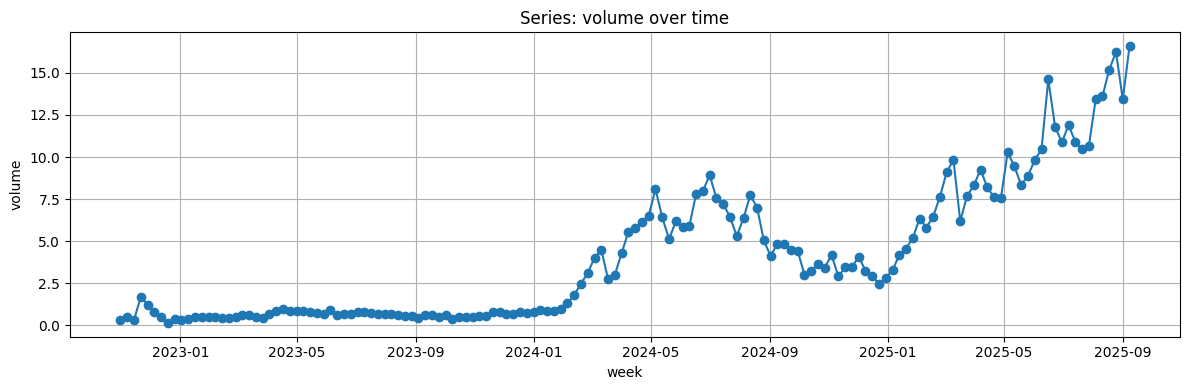

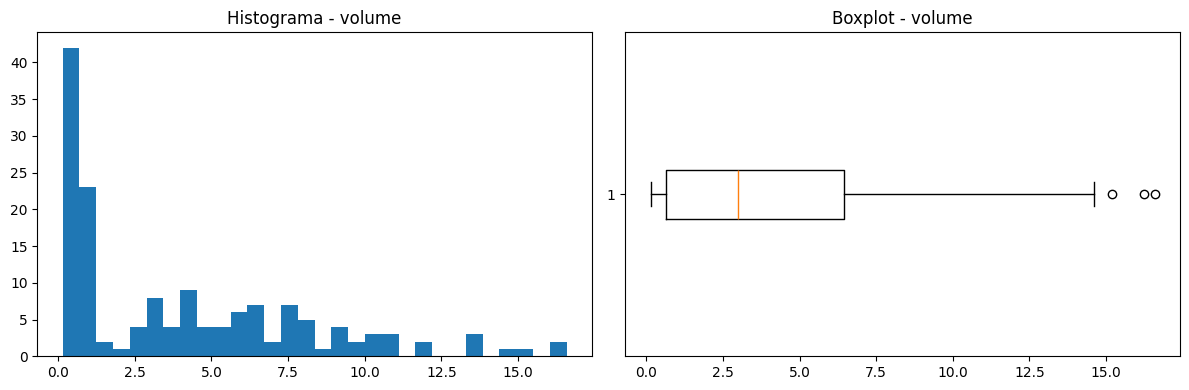

Valores missing em 'volume': 0


In [6]:
# Análise exploratória

plt.figure(figsize=(12,4))
plt.plot(series, marker='o', linestyle='-')
plt.title('Series: volume over time')
plt.ylabel('volume')
plt.xlabel('week')
plt.grid(True)
plt.tight_layout()
plt.show()

# histograma e boxplot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(series.dropna(), bins=30)
plt.title('Histograma - volume')
plt.subplot(1,2,2)
plt.boxplot(series.dropna(), vert=False)
plt.title('Boxplot - volume')
plt.tight_layout()
plt.show()

# verificar ausentes
n_missing = series.isna().sum()
print(f"Valores missing em 'volume': {n_missing}")


In [ ]:
print("Intervalo dos dados:", series["volume"].min(),",", series["volume"].max())
print(len(series[series["volume"] <1]), "valores menores que 1", )

In [ ]:
print(len(series[series["volume"] <1]), "valores menores que 1", )

In [7]:
# Testes de estacionariedade: ADF e KPSS

from statsmodels.tsa.stattools import adfuller, kpss

def test_stationarity(y):
    print('\n--- Teste de estacionariedade ---')
    y_clean = y.dropna()
    adf_res = adfuller(y_clean, autolag='AIC')
    print(f"ADF: stat={adf_res[0]:.4f}, p-val={adf_res[1]:.4f}, n_lags={adf_res[2]}")
    print('ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária')

    kpss_res = kpss(y_clean, regression='c', nlags='auto')
    print(f"KPSS: stat={kpss_res[0]:.4f}, p-val={kpss_res[1]:.4f}")
    print('KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária')

test_stationarity(series)


--- Teste de estacionariedade ---
ADF: stat=1.0022, p-val=0.9943, n_lags=2
ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária
KPSS: stat=1.4012, p-val=0.0100
KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária


C:\Users\dudda\AppData\Local\Temp\ipykernel_12044\2181536600.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(y_clean, regression='c', nlags='auto')


In [8]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

# Função de teste
def test_stationarity(y):
    print('\n--- Teste de estacionariedade ---')
    y_clean = y.dropna()

    adf_res = adfuller(y_clean, autolag='AIC')
    print(f"ADF: stat={adf_res[0]:.4f}, p-val={adf_res[1]:.4f}, n_lags={adf_res[2]}")
    print('ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária')

    kpss_res = kpss(y_clean, regression='c', nlags='auto')
    print(f"KPSS: stat={kpss_res[0]:.4f}, p-val={kpss_res[1]:.4f}")
    print('KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária')

# Evita warnings chatos
warnings.filterwarnings("ignore", category=InterpolationWarning)

# 1ª diferença
series_diff = series.diff().dropna()

print("=== Série original ===")
test_stationarity(series)

print("\n=== Série diferenciada (1ª diferença) ===")
test_stationarity(series_diff)


=== Série original ===

--- Teste de estacionariedade ---
ADF: stat=1.0022, p-val=0.9943, n_lags=2
ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária
KPSS: stat=1.4012, p-val=0.0100
KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária

=== Série diferenciada (1ª diferença) ===

--- Teste de estacionariedade ---
ADF: stat=-10.8391, p-val=0.0000, n_lags=1
ADF: se p < 0.05, rejeita H0 de raiz unitária -> estacionária
KPSS: stat=0.3090, p-val=0.1000
KPSS: se p < 0.05, rejeita H0 de estacionariedade -> não estacionária



Transformações possíveis: log e Box-Cox (se scipy disponível)
Box-Cox aplicado. lambda=0.0496

Exemplo: plot da diferença (primeira ordem)


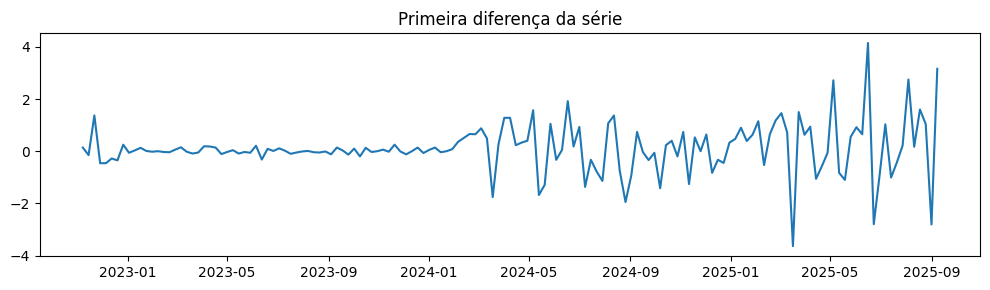

In [11]:
# Verifica se scipy está disponível
try:
    import scipy.stats as stats
    SCIPY_AVAILABLE = True
except ImportError:
    SCIPY_AVAILABLE = False

# Criar cópia da série e verificar valores
series_pos = series.copy()

if (series_pos <= 0).any():
    print('\nAlguns valores não-positivos encontrados — Box-Cox e log não são aplicáveis diretamente.')
    series_log = None
    series_bc = None
else:
    print('\nTransformações possíveis: log e Box-Cox (se scipy disponível)')
    
    # aplicar log
    series_log = np.log(series_pos)
    
    # aplicar Box-Cox se scipy disponível
    if SCIPY_AVAILABLE:
        series_bc, bc_lambda = stats.boxcox(series_pos)
        print(f'Box-Cox aplicado. lambda={bc_lambda:.4f}')
    else:
        series_bc = None

# diferença de primeira ordem para estacionarizar tendência
series_diff = series.diff().dropna()

# plot da diferença
print('\nExemplo: plot da diferença (primeira ordem)')
plt.figure(figsize=(10,3))
plt.plot(series_diff)
plt.title('Primeira diferença da série')
plt.tight_layout()
plt.show()


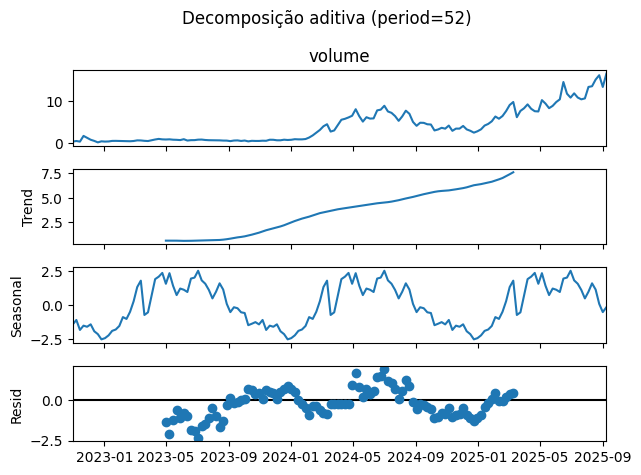

In [12]:
# Decomposição da série
# definiremos o periodo sazonal para dados semanais com 52 semanas
SEASONAL_PERIOD = 52
try:
    decomp = seasonal_decompose(series.dropna(), model='additive', period=SEASONAL_PERIOD)
    decomp.plot()
    plt.suptitle('Decomposição aditiva (period=52)')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Erro na decomposição (provável que a série seja curta ou period inválido):', e)

In [13]:
# Split treino/teste
train, test = train_test_split_ts(series.to_frame(), test_size=0.2)
train_s = train['volume']
test_s = test['volume']
print(f"\nTreino: {len(train_s)} obs, Teste: {len(test_s)} obs")


Treino: 120 obs, Teste: 30 obs


In [14]:
# Baselines
results = []

# 1) Naive forecast: predição = último valor do treino
naive_pred = np.repeat(train_s.iloc[-1], len(test_s))
results.append(('Naive', naive_pred))

# 2) Seasonal Naive: se sazonalidade conhecida (period=52), predição = valor de t-period
if len(train_s) >= SEASONAL_PERIOD:
    seasonal_naive = []
    for idx in test_s.index:
        # usar valor do mesmo periodo (periodo semanas) do último ano
        try:
            seasonal_naive.append(train_s.loc[idx - pd.DateOffset(weeks=SEASONAL_PERIOD)])
        except Exception:
            # fallback: usar valor da posição -period relativa ao fim do treino
            seasonal_naive.append(train_s.iloc[-SEASONAL_PERIOD + (len(seasonal_naive) % SEASONAL_PERIOD)])
    seasonal_naive = np.array(seasonal_naive)
    results.append(('SeasonalNaive', seasonal_naive))

# 3) Rolling mean (últimos k)
K = 4
rolling_mean_pred = np.repeat(train_s.tail(K).mean(), len(test_s))
results.append((f'RollingMean_k{K}', rolling_mean_pred))

# avaliar baselines
base_eval = []
for name, pred in results:
    mae = mean_absolute_error(test_s, pred)
    r = rmse(test_s, pred)
    m = mape(test_s, pred)
    base_eval.append({'model': name, 'MAE': mae, 'RMSE': r, 'MAPE': m})

base_eval_df = pd.DataFrame(base_eval)
print('\nBaseline results:')
print(base_eval_df)



Baseline results:
            model       MAE      RMSE       MAPE
0           Naive  4.680333  5.441076  40.788894
1   SeasonalNaive  4.759333  5.402674  44.010046
2  RollingMean_k4  5.015333  5.731784  44.202960


In [16]:
# Regressão linear múltipla com features temporais

X = pd.DataFrame(index=train_s.index)
X['t'] = np.arange(len(train_s))
X['sin52'] = np.sin(2 * np.pi * X['t'] / SEASONAL_PERIOD)
X['cos52'] = np.cos(2 * np.pi * X['t'] / SEASONAL_PERIOD)

if isinstance(train_s.index, pd.DatetimeIndex):
    # Semana do ano
    X['weekofyear'] = train_s.index.isocalendar().week.astype(int).values
    # Dummies de mês
    month_dummies = pd.get_dummies(train_s.index.month, prefix='m', drop_first=True)
    month_dummies.index = train_s.index  # alinhando índices
    X = pd.concat([X, month_dummies], axis=1)


# Ajustar regressão
lr = LinearRegression()
lr.fit(X, train_s.values)

print('\nCoeficientes da regressão multivariada:')
for name, coef in zip(X.columns, lr.coef_):
    print(f"{name}: {coef:.4f}")


# Construir features para teste
X_test = pd.DataFrame(index=test_s.index)
X_test['t'] = np.arange(len(train_s), len(train_s) + len(test_s))
X_test['sin52'] = np.sin(2 * np.pi * X_test['t'] / SEASONAL_PERIOD)
X_test['cos52'] = np.cos(2 * np.pi * X_test['t'] / SEASONAL_PERIOD)

if isinstance(train_s.index, pd.DatetimeIndex):
    X_test['weekofyear'] = test_s.index.isocalendar().week.astype(int).values
    month_dummies_test = pd.get_dummies(test_s.index.month, prefix='m', drop_first=True)
    month_dummies_test.index = test_s.index
    X_test = pd.concat([X_test, month_dummies_test], axis=1)

# Alinhar colunas
for c in X.columns:
    if c not in X_test.columns:
        X_test[c] = 0
X_test = X_test[X.columns]

# Previsão e avaliação
reg_pred = lr.predict(X_test)

lr_mae = mean_absolute_error(test_s, reg_pred)
lr_rmse = rmse(test_s, reg_pred)
lr_mape = mape(test_s, reg_pred)

print(f"\nRegressão linear: MAE={lr_mae:.3f}, RMSE={lr_rmse:.3f}, MAPE={lr_mape:.2f}%")

# Armazenar resultados
model_eval = []
model_eval.append({'model': 'LinearRegression', 'MAE': lr_mae, 'RMSE': lr_rmse, 'MAPE': lr_mape})



Coeficientes da regressão multivariada:
t: 0.0536
sin52: -0.2633
cos52: -0.7769
weekofyear: 0.0303
m_2: 0.2010
m_3: 0.0706
m_4: 0.7038
m_5: 0.2950
m_6: 0.3551
m_7: 0.3814
m_8: 0.0828
m_9: -0.8424
m_10: -1.3475
m_11: -0.6617
m_12: -1.3444

Regressão linear: MAE=3.161, RMSE=4.055, MAPE=26.44%


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# --- Funções auxiliares ---
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

def sarima_optimized_search(train, s=52):
    """
    Busca SARIMA otimizada: testa apenas combinações plausíveis de (p,d,q)x(P,D,Q,s)
    e retorna o modelo com menor AIC.
    """
    # Combinações mais comuns para séries semanais
    pdq = [(0,1,1), (1,1,0), (1,1,1), (0,1,0)]
    seasonal_pdq = [(0,1,1), (1,1,0), (1,1,1), (0,1,0)]
    
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    for order in pdq:
        for seasonal in seasonal_pdq:
            seasonal_order = (*seasonal, s)
            try:
                model = SARIMAX(
                    train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_model = results
            except Exception:
                continue
                
    return best_model, best_order, best_seasonal_order, best_aic

# --- Exemplo de dados ---
data = pd.Series(
    [100, 105, 102, 108, 110, 115, 120, 125, 123, 130, 128, 135],
    index=pd.date_range(start='2025-01-01', periods=12, freq='W')
)

train_s = data[:8]  # treino
test_s = data[8:]   # teste

# --- Inicializar lista de resultados ---
model_eval = []

# --- Busca SARIMA otimizada ---
s = 52  # sazonalidade semanal
best_model, best_order, best_seasonal_order, best_aic = sarima_optimized_search(train_s.values, s=s)

print(f"Melhor modelo SARIMA: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")

# --- Previsão ---
arima_pred = best_model.forecast(steps=len(test_s))

# --- Avaliação ---
arima_mae = mean_absolute_error(test_s, arima_pred)
arima_rmse = rmse(test_s.values, arima_pred)
arima_mape = mape(test_s.values, arima_pred)

print(f"\nSARIMA: MAE={arima_mae:.3f}, RMSE={arima_rmse:.3f}, MAPE={arima_mape:.2f}%")

# --- Armazenar resultados ---
model_eval.append({
    'model': 'SARIMA',
    'MAE': arima_mae,
    'RMSE': arima_rmse,
    'MAPE': arima_mape
})

print("\nResultados armazenados:", model_eval)

C:\Users\dudda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dudda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dudda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for sli

Melhor modelo SARIMA: order=(0, 1, 0), seasonal_order=(0, 1, 0, 52), AIC=2.00

SARIMA: MAE=5.000, RMSE=5.874, MAPE=3.81%

Resultados armazenados: [{'model': 'SARIMA', 'MAE': 5.0, 'RMSE': np.float64(5.873670062235365), 'MAPE': np.float64(3.805831878430964)}]


C:\Users\dudda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


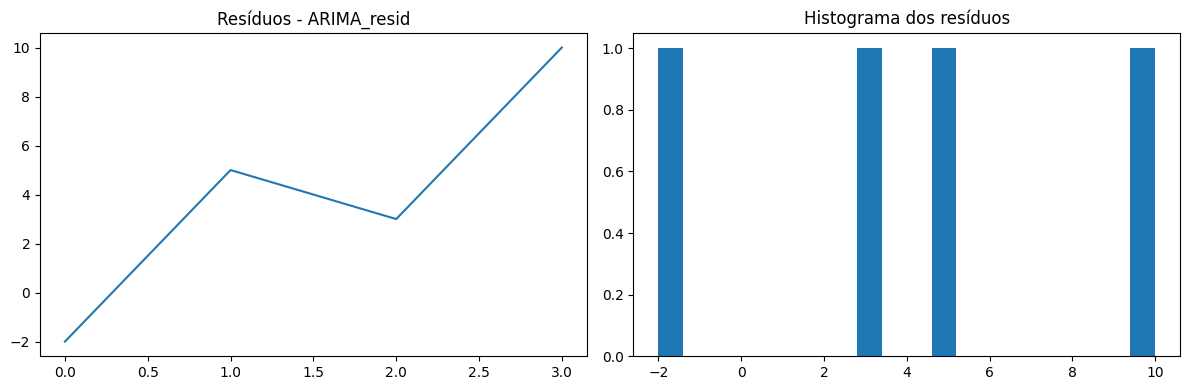

ValueError: could not broadcast input array from shape (4,) into shape (41,)

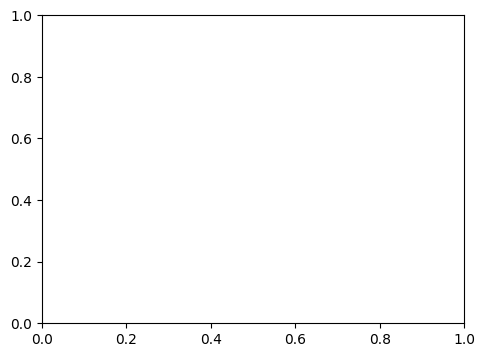

In [10]:
# Diagnóstico de resíduos para o melhor modelo (exemplo: SARIMAX/resíduos de regressão)
# escolher resíduos do modelo SARIMA se existir, senão da regressão
residuals = None
if arima_pred is not None:
    residuals = test_s.values - arima_pred
    res_name = 'ARIMA_resid'
else:
    residuals = test_s.values - reg_pred
    res_name = 'LR_resid'

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(residuals)
plt.title(f'Resíduos - {res_name}')
plt.subplot(1,2,2)
plt.hist(residuals, bins=20)
plt.title('Histograma dos resíduos')
plt.tight_layout()
plt.show()

# ACF/PACF
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_acf(residuals, ax=plt.gca(), lags=40)
plt.subplot(1,2,2)
plot_pacf(residuals, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

# Ljung-Box
lb = acorr_ljungbox(residuals, lags=[10,20], return_df=True)
print('\nLjung-Box test (resíduos):')
print(lb)

In [11]:
# Comparação final de modelos (baselines + regression + arima if available)
# compilar resultados
if 'base_eval_df' in globals():
    comp = base_eval_df.copy()
else:
    comp = pd.DataFrame()

comp = comp.append(pd.DataFrame(model_eval), ignore_index=True, sort=False).fillna('-')
print('\nComparação de modelos:')
print(comp.sort_values('RMSE'))

# ---------------------
# Salvar previsões e resultados
# ---------------------
out_dir = Path('results')
out_dir.mkdir(exist_ok=True)

# salvar previsões dos modelos testados
predictions = pd.DataFrame(index=test_s.index)
predictions['actual'] = test_s.values
# baselines
for name, pred in results:
    predictions[name] = pred
# regression
predictions['LinearRegression'] = reg_pred
# arima
if arima_pred is not None:
    predictions['ARIMA'] = arima_pred

predictions.to_csv(out_dir / 'predictions.csv')
comp.to_csv(out_dir / 'model_comparison.csv', index=False)

print(f"\nArquivos salvos em: {out_dir.resolve()}\n - predictions.csv\n - model_comparison.csv")

AttributeError: 'DataFrame' object has no attribute 'append'

## Regressão linear múltipla

In [82]:
"""
ts_analysis_script.py

Análise completa de séries temporais com:
 - Regressão linear múltipla (tendência + harmônicos sazonais + dummies de mês)
 - Modelos ARIMA/SARIMA (statsmodels; opcional: pmdarima.auto_arima)
 - Resultados para diagnóstico de resíduos (ACF/PACF, Ljung-Box, histograma, QQplot)
 - Comparação por AIC/BIC/RMSE/MAPE
 - Exportação de resultados e plots

Salva resultados em ./results_linear_regression/
"""

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from io import StringIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# -------------------------
# Configurações gerais
# -------------------------
OUTDIR = Path("./results_linear_regression")
OUTDIR.mkdir(parents=True, exist_ok=True)

data_csv = "data.csv"
# data_csv = """week,volume
#               2022-10-31,0.33
#               ...
#            """

INPUT_CSV_PATH = Path("data.csv")  # usado se data_csv for None

# Parâmetros de modelagem
SEASONAL_PERIOD = 52        # sazonalidade anual em semanas (~52, uma ano)
TEST_SIZE = 12              # número de semanas no conjunto de teste para validação
SARIMAX_GRID_SMALL = {
    "p": [0, 1, 2],
    "d": [0, 1],
    "q": [0, 1],
    "P": [0, 1],
    "D": [0, 1],
    "Q": [0, 1],
}


In [83]:
# -------------------------
# Funções utilitárias
# -------------------------
INPUT_CSV_PATH = "data.csv"  # caminho do arquivo local

def load_data():
    """Carrega os dados do CSV (arquivo) e prepara a série temporal."""
    df = pd.read_csv(INPUT_CSV_PATH, parse_dates=["week"])
    df = df.sort_values("week").reset_index(drop=True)
    df = df.set_index("week")
    df.index = pd.to_datetime(df.index)

    # Garantir numérico
    df["volume"] = pd.to_numeric(df["volume"], errors="coerce")

    # Interpolar eventuais gaps (caso haja)
    df["volume"] = df["volume"].interpolate()

    return df



def evaluate(y_true, y_pred, model=None):
    """Calcula métricas de avaliação."""
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results = {"rmse": float(rmse), "mape": float(mape), "r2": float(r2)}
    
    if model is not None:
        results["r2_adj"] = float(model.rsquared_adj)
        results["std_err_reg"] = float(model.mse_resid ** 0.5)
    
    return results



In [84]:
# -------------------------
# Carregamento e features
# -------------------------
df = load_data()
df.to_csv(OUTDIR / "data_used.csv") # ordena por data, interpola se tiver valores faltantes.

data = df.reset_index()
T = len(data)
data["t"] = np.arange(1, T + 1)  # tendência (linear) , que cresce de 1 até T, para capturar crescimento/queda ao longo do tempo.

# Harmônicos para sazonalidade (1º e 2º harmônicos)
data["sin1"] = np.sin(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos1"] = np.cos(2 * np.pi * data["t"] / SEASONAL_PERIOD)
data["sin2"] = np.sin(4 * np.pi * data["t"] / SEASONAL_PERIOD)
data["cos2"] = np.cos(4 * np.pi * data["t"] / SEASONAL_PERIOD)

# Dummies para mês (poderia ser semana do ano, dia da semana, etc.)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True)
data = pd.concat([data, month_dummies], axis=1)
# print(data)

# Preditores para regressão
predictors = ["t", "sin1", "cos1", "sin2", "cos2"] + list(month_dummies.columns) # variáveis explicativas.
X_all = sm.add_constant(data[predictors]) # adiciona a constante (intercepto) ao modelo.
y_all = data["volume"] # variável resposta (a série volume).


# Criar preditores
t = np.arange(len(data))
X_all = pd.DataFrame({"t": t})
for k in range(1, 3):
    X_all[f"sin{k}"] = np.sin(2*np.pi*k*t/SEASONAL_PERIOD)
    X_all[f"cos{k}"] = np.cos(2*np.pi*k*t/SEASONAL_PERIOD)

# Dummies de mês (converter direto para float)
data["month"] = data["week"].dt.month
month_dummies = pd.get_dummies(data["month"], prefix="m", drop_first=True).astype(float)

X_all = pd.concat([X_all, month_dummies], axis=1)
X_all = sm.add_constant(X_all).astype(float)

y_all = data["volume"].astype(float)


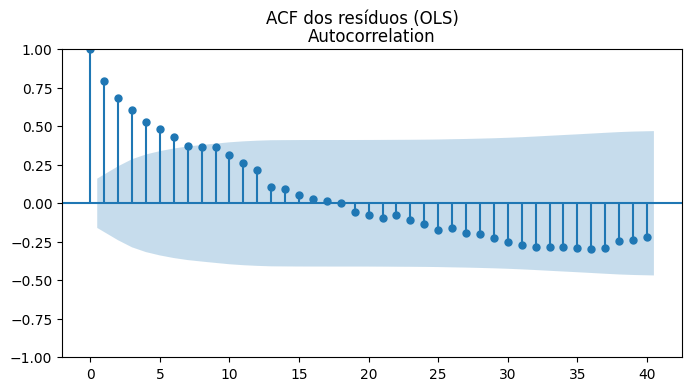

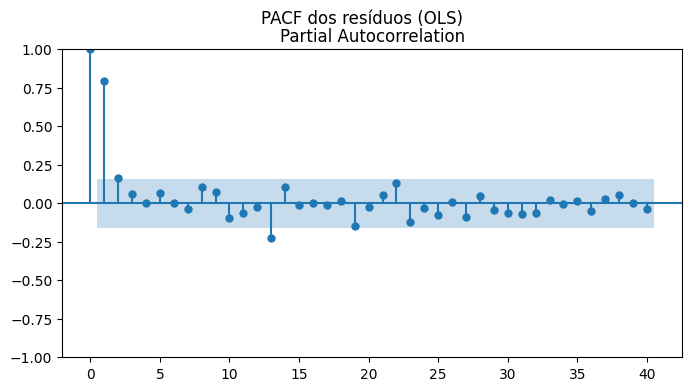

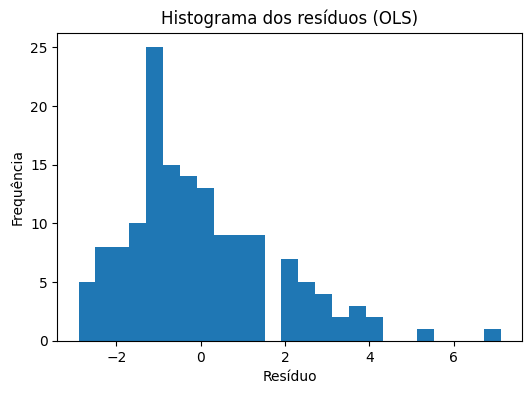

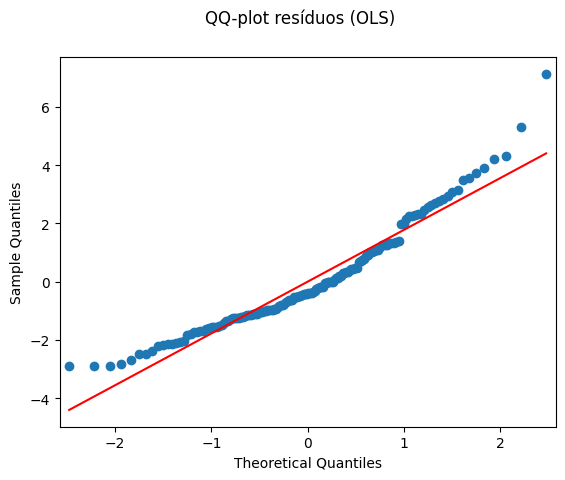

In [ ]:
# -------------------------
# Regressão OLS (full sample)
# -------------------------

#Ajuste do modelo OLS (Mínimos Quadrados Ordinários)
ols_full = sm.OLS(y_all, X_all).fit() #estima os coeficientes que minimizam a soma dos erros quadrados.
(OUTDIR / "ols_summary.txt").write_text(ols_full.summary().as_text()) # gera estatísticas do modelo (coeficientes, R², p-values, etc.)

# Residual diagnostics (OLS)

#vetor de resíduos. São usados para avaliar se o modelo capturou bem a estrutura da série.
resid = ols_full.resid  

# ACF (Autocorrelation Function): mede se os resíduos estão correlacionados ao longo do tempo. 
# Idealmente, resíduos devem ser ruído branco → sem autocorrelação significativa. 
# Se houver autocorrelação, significa que o modelo não capturou toda a dependência temporal.
fig = plt.figure(figsize=(8,4))
plot_acf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF dos resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_acf.png") 
plt.show()
plt.close(fig)

# PACF (Partial Autocorrelation Function): mostra a autocorrelação de uma defasagem, condicionada às defasagens anteriores.
# Ajuda a detectar se ainda existe estrutura AR (autoregressiva) nos resíduos.
fig = plt.figure(figsize=(8,4)) 
plot_pacf(resid, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF dos resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_pacf.png")
plt.show()
plt.close(fig)

# Histograma dos resíduos
# Verifica se os resíduos seguem uma distribuição aproximadamente normal (hipótese da regressão linear).
# Se houver caudas pesadas ou assimetria, pode indicar problemas no ajuste.
fig = plt.figure(figsize=(6,4))
plt.hist(resid, bins=25)
plt.title("Histograma dos resíduos (OLS)")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
fig.savefig(OUTDIR / "ols_resid_hist.png")
plt.show()
plt.close(fig)

# QQ-plot (Quantile-Quantile)
# Compara os quantis dos resíduos com os quantis de uma distribuição normal.
# Se os pontos seguirem a linha → resíduos são aproximadamente normais.
# Se houver desvios nas caudas → problemas de heterocedasticidade ou não-normalidade.
fig = qqplot(resid, line="s")
fig.suptitle("QQ-plot resíduos (OLS)")
fig.savefig(OUTDIR / "ols_resid_qq.png")
plt.show()
plt.close(fig)

# Teste de Ljung-Box
lb = acorr_ljungbox(resid, lags=[10, 20], return_df=True)
lb.to_csv(OUTDIR / "ols_ljungbox.csv")


In [86]:
# -------------------------
# Treino / Teste (para comparar previsões)
# -------------------------

train = data.iloc[:-TEST_SIZE].copy()
test = data.iloc[-TEST_SIZE:].copy()

y_train = train["volume"]
y_test = test["volume"]

X_train = sm.add_constant(train[predictors])
X_test = sm.add_constant(test[predictors])

y_train = pd.to_numeric(y_train, errors="coerce").astype(float)
y_test = pd.to_numeric(y_test, errors="coerce").astype(float)

X_train = X_train.apply(pd.to_numeric, errors="coerce").astype(float)
X_test = X_test.apply(pd.to_numeric, errors="coerce").astype(float)



ols_train = sm.OLS(y_train, X_train).fit()
reg_pred = ols_train.predict(X_test)
reg_metrics = evaluate(y_test, reg_pred)

pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_true": y_test.values,
    "reg_pred": reg_pred.values
})


In [ ]:
# -------------------------
# SARIMAX modeling
# - Tenta usar pmdarima.auto_arima se disponível (mais prático)
# - Se não, faz um grid search pequeno com statsmodels.SARIMAX
# -------------------------
use_auto = False
try:
    import pmdarima as pm
    use_auto = True
except Exception:
    use_auto = False

sarimax_results = []
if use_auto:
    # auto_arima (rápido se stepwise; precisa de pmdarima instalado)
    auto = pm.auto_arima(y_train, seasonal=True, m=SEASONAL_PERIOD,
                         stepwise=True, suppress_warnings=True, error_action="ignore")
    order = auto.order
    seasonal_order = auto.seasonal_order
    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    res = model.fit(disp=False)
    sarimax_results.append({"model": f"AUTO ({order}) x {seasonal_order}", "aic": res.aic, "bic": res.bic, "res": res})
else:
    # Grid search conservador (ajuste os ranges em SARIMAX_GRID_SMALL para explorar mais)
    p_range = SARIMAX_GRID_SMALL["p"]
    d_range = SARIMAX_GRID_SMALL["d"]
    q_range = SARIMAX_GRID_SMALL["q"]
    P_range = SARIMAX_GRID_SMALL["P"]
    D_range = SARIMAX_GRID_SMALL["D"]
    Q_range = SARIMAX_GRID_SMALL["Q"]
    m = SEASONAL_PERIOD

    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                mod = SARIMAX(y_train, order=(p,d,q), seasonal_order=(P,D,Q,m),
                                              enforce_stationarity=False, enforce_invertibility=False)
                                res = mod.fit(disp=False, low_memory=True)
                                sarimax_results.append({
                                    "model": f"SARIMAX ({p},{d},{q}) x ({P},{D},{Q},{m})",
                                    "aic": res.aic, "bic": res.bic, "res": res
                                })
                            except Exception as e:
                                # falhas de convergência são normais em grid search; ignoramos
                                continue

# Se não houve modelos (por falha), interrompa
if len(sarimax_results) == 0:
    raise RuntimeError("Não foi possível ajustar nenhum modelo SARIMAX. Tente ajustar ranges menores ou instalar pmdarima.")

# Ordena por AIC e guarda top models
sarimax_results = sorted(sarimax_results, key=lambda x: x["aic"])
top_results = sarimax_results[:5]
# salva summaries
summaries_txt = ""
for i, item in enumerate(top_results):
    summaries_txt += f"Model {i+1}: {item['model']}  AIC={item['aic']:.2f}  BIC={item['bic']:.2f}\n"
    summaries_txt += item["res"].summary().as_text()
    summaries_txt += "\n\n" + ("-"*80) + "\n\n"
(OUTDIR / "sarimax_summaries.txt").write_text(summaries_txt)

# Escolhe o melhor para previsões (top_results[0])
best_res = top_results[0]["res"]

# Forecasting (estático/determinístico): preve as próximas TEST_SIZE semanas
sarimax_forecast_obj = best_res.get_forecast(steps=TEST_SIZE)
sarimax_pred_mean = sarimax_forecast_obj.predicted_mean
# Alinha índices com as semanas reais do conjunto de teste
sarimax_pred_mean.index = test["week"].values

sarimax_metrics = evaluate(y_test, sarimax_pred_mean)

pred_df["sarimax_pred"] = sarimax_pred_mean.values
pred_df.to_csv(OUTDIR / "model_predictions_comparison.csv", index=False)


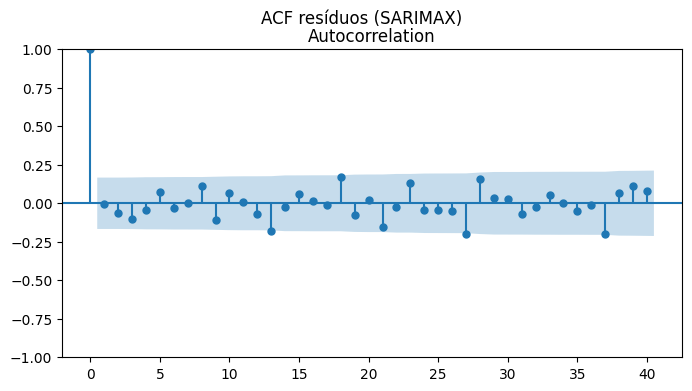

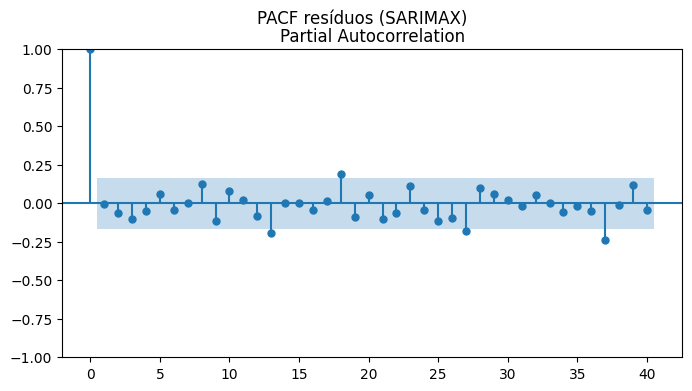

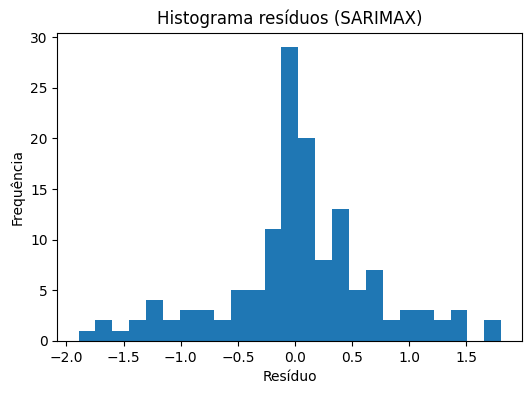

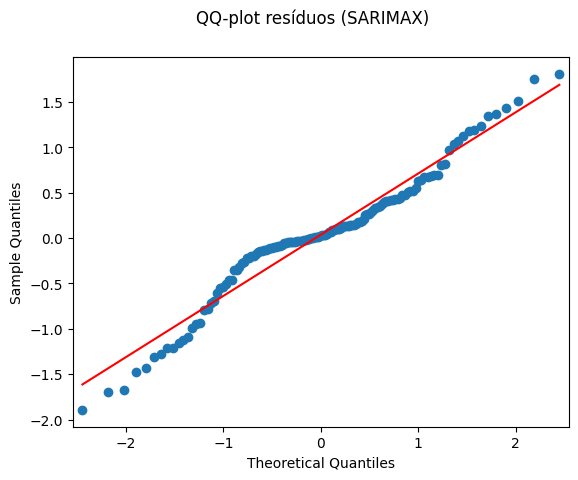

In [93]:

# Residual diagnostics (melhor SARIMAX)
resid_s = best_res.resid
fig = plt.figure(figsize=(8,4))
plot_acf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("ACF resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_acf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(8,4))
plot_pacf(resid_s, lags=40, ax=fig.add_subplot(111))
fig.suptitle("PACF resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_pacf.png")
plt.show()
plt.close(fig)

fig = plt.figure(figsize=(6,4))
plt.hist(resid_s, bins=25)
plt.title("Histograma resíduos (SARIMAX)")
plt.xlabel("Resíduo"); plt.ylabel("Frequência")
fig.savefig(OUTDIR / "sarimax_resid_hist.png") 
plt.show()
plt.close(fig)

fig = qqplot(resid_s, line="s")
fig.suptitle("QQ-plot resíduos (SARIMAX)")
fig.savefig(OUTDIR / "sarimax_resid_qq.png")
plt.show()
plt.close(fig)

lb_s = acorr_ljungbox(resid_s, lags=[10, 20], return_df=True)
lb_s.to_csv(OUTDIR / "sarimax_ljungbox.csv")




In [88]:
# -------------------------
# Comparação final e salvamento
# -------------------------
comparison = pd.DataFrame([
    {
        "model": "Regression (trend+harmonics+month dummies)",
        "aic": np.nan, "bic": np.nan,
        "rmse": reg_metrics["rmse"], "mape": reg_metrics["mape"]
    },
    {
        "model": top_results[0]["model"],
        "aic": top_results[0]["aic"], "bic": top_results[0]["bic"],
        "rmse": sarimax_metrics["rmse"], "mape": sarimax_metrics["mape"]
    }
])
comparison.to_csv(OUTDIR / "model_comparison.csv", index=False)

# Save a short human-readable summary
summary = f"""
Análise completa salva em: {OUTDIR.resolve()}
Regressão (teste último {TEST_SIZE}): RMSE={reg_metrics['rmse']:.4f}, MAPE={reg_metrics['mape']:.4f}
SARIMAX (teste último {TEST_SIZE}): RMSE={sarimax_metrics['rmse']:.4f}, MAPE={sarimax_metrics['mape']:.4f}
Melhor SARIMAX: {top_results[0]['model']} (AIC={top_results[0]['aic']:.2f}, BIC={top_results[0]['bic']:.2f})
"""
(OUTDIR / "readme_results.txt").write_text(summary)
print(summary)

# Lista arquivos gerados
print("Arquivos gerados:")
for p in sorted(OUTDIR.iterdir()):
    print("-", p.name)



Análise completa salva em: C:\Users\Paula Eduarda\OneDrive - Fundacao Getulio Vargas - FGV\Documentos\6º período\Séries Temporais\time-series\results_linear_regression
Regressão (teste último 12): RMSE=5.1834, MAPE=0.3303
SARIMAX (teste último 12): RMSE=3.2793, MAPE=0.2212
Melhor SARIMAX: SARIMAX (0,1,1) x (0,1,1,52) (AIC=83.05, BIC=87.36)

Arquivos gerados:
- data_used.csv
- model_comparison.csv
- model_predictions_comparison.csv
- ols_ljungbox.csv
- ols_resid_acf.png
- ols_resid_hist.png
- ols_resid_pacf.png
- ols_resid_qq.png
- ols_summary.txt
- readme_results.txt
- sarimax_ljungbox.csv
- sarimax_resid_acf.png
- sarimax_resid_hist.png
- sarimax_resid_pacf.png
- sarimax_resid_qq.png
- sarimax_summaries.txt


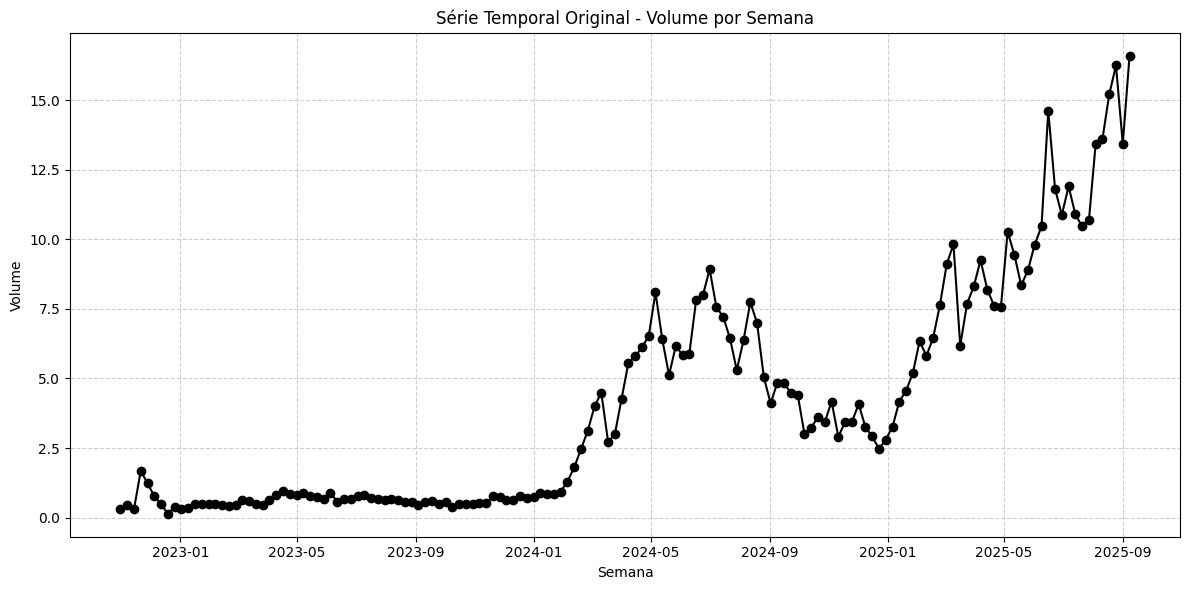

In [89]:
# garante que 'week' está em datetime
df_check["week"] = pd.to_datetime(df_check["week"])

plt.figure(figsize=(12,6))
plt.plot(df_check["week"], df_check["volume"], marker="o", linestyle="-", color="black")

plt.title("Série Temporal Original - Volume por Semana")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

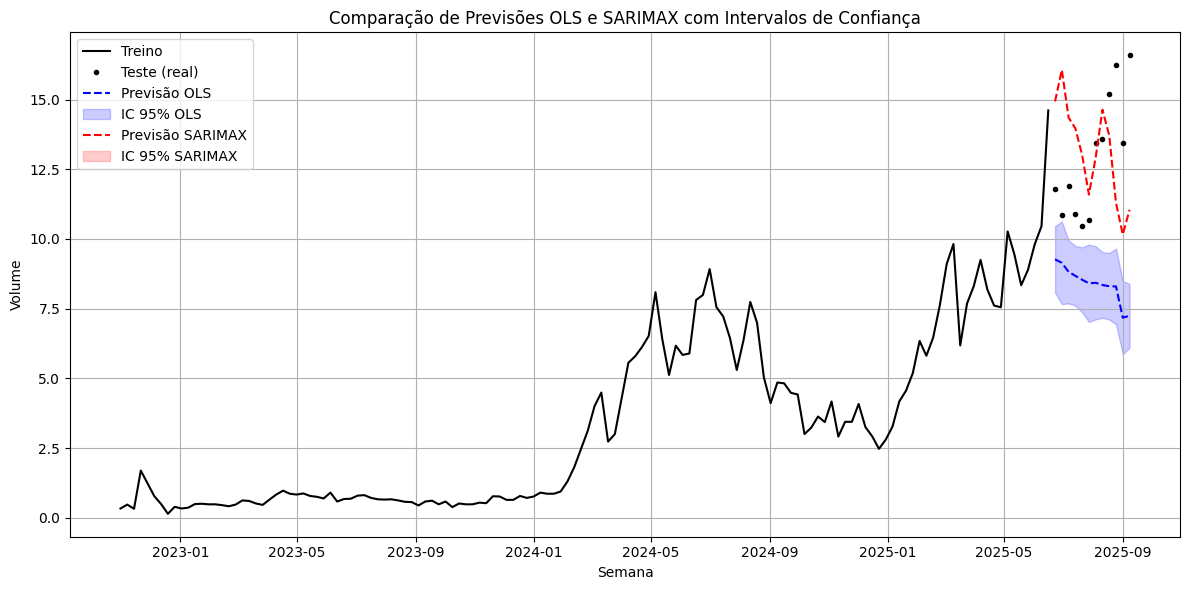

In [104]:
# -------------------------
# Preparar previsões com IC
# -------------------------

# 1️⃣ Previsão OLS
ols_forecast_obj = ols_train.get_prediction(X_test)
ols_pred_mean = ols_forecast_obj.predicted_mean
ols_ci = ols_forecast_obj.conf_int(alpha=0.05)

ols_pred_df = pd.DataFrame({
    "week": test["week"].values,
    "y_pred": ols_pred_mean,
    "ci_lower": ols_ci[:, 0],
    "ci_upper": ols_ci[:, 1]
})

# 2️⃣ Previsão SARIMAX
sarimax_forecast_obj = best_res.get_forecast(steps=len(test))
sarimax_forecast_df = sarimax_forecast_obj.summary_frame(alpha=0.05)

# Garantir alinhamento correto com o eixo x
sarimax_pred_df = sarimax_forecast_df.copy()
sarimax_pred_df["week"] = test["week"].values
sarimax_pred_df.rename(columns={
    "mean": "y_pred",
    "mean_ci_lower": "ci_lower",
    "mean_ci_upper": "ci_upper"
}, inplace=True)

# -------------------------
# Plotagem
# -------------------------
plt.figure(figsize=(12,6))

# Treino
plt.plot(train["week"], train["volume"], color="black", linestyle="-", label="Treino")

# Teste (real)
plt.plot(test["week"], test["volume"], color="black", marker=".", linestyle="None", label="Teste (real)")

# OLS
plt.plot(ols_pred_df["week"], ols_pred_df["y_pred"], color="blue", linestyle="--", label="Previsão OLS")
plt.fill_between(ols_pred_df["week"], ols_pred_df["ci_lower"], ols_pred_df["ci_upper"],
                 color="blue", alpha=0.2, label="IC 95% OLS")

# SARIMAX
plt.plot(sarimax_pred_df["week"], sarimax_pred_df["y_pred"], color="red", linestyle="--", label="Previsão SARIMAX")
plt.fill_between(sarimax_pred_df["week"], sarimax_pred_df["ci_lower"], sarimax_pred_df["ci_upper"],
                 color="red", alpha=0.2, label="IC 95% SARIMAX")

# Estilo e labels
plt.title("Comparação de Previsões OLS e SARIMAX com Intervalos de Confiança")
plt.xlabel("Semana")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Salvar e mostrar
plt.savefig(OUTDIR / "forecast_comparison.png")
plt.show()
plt.close()
